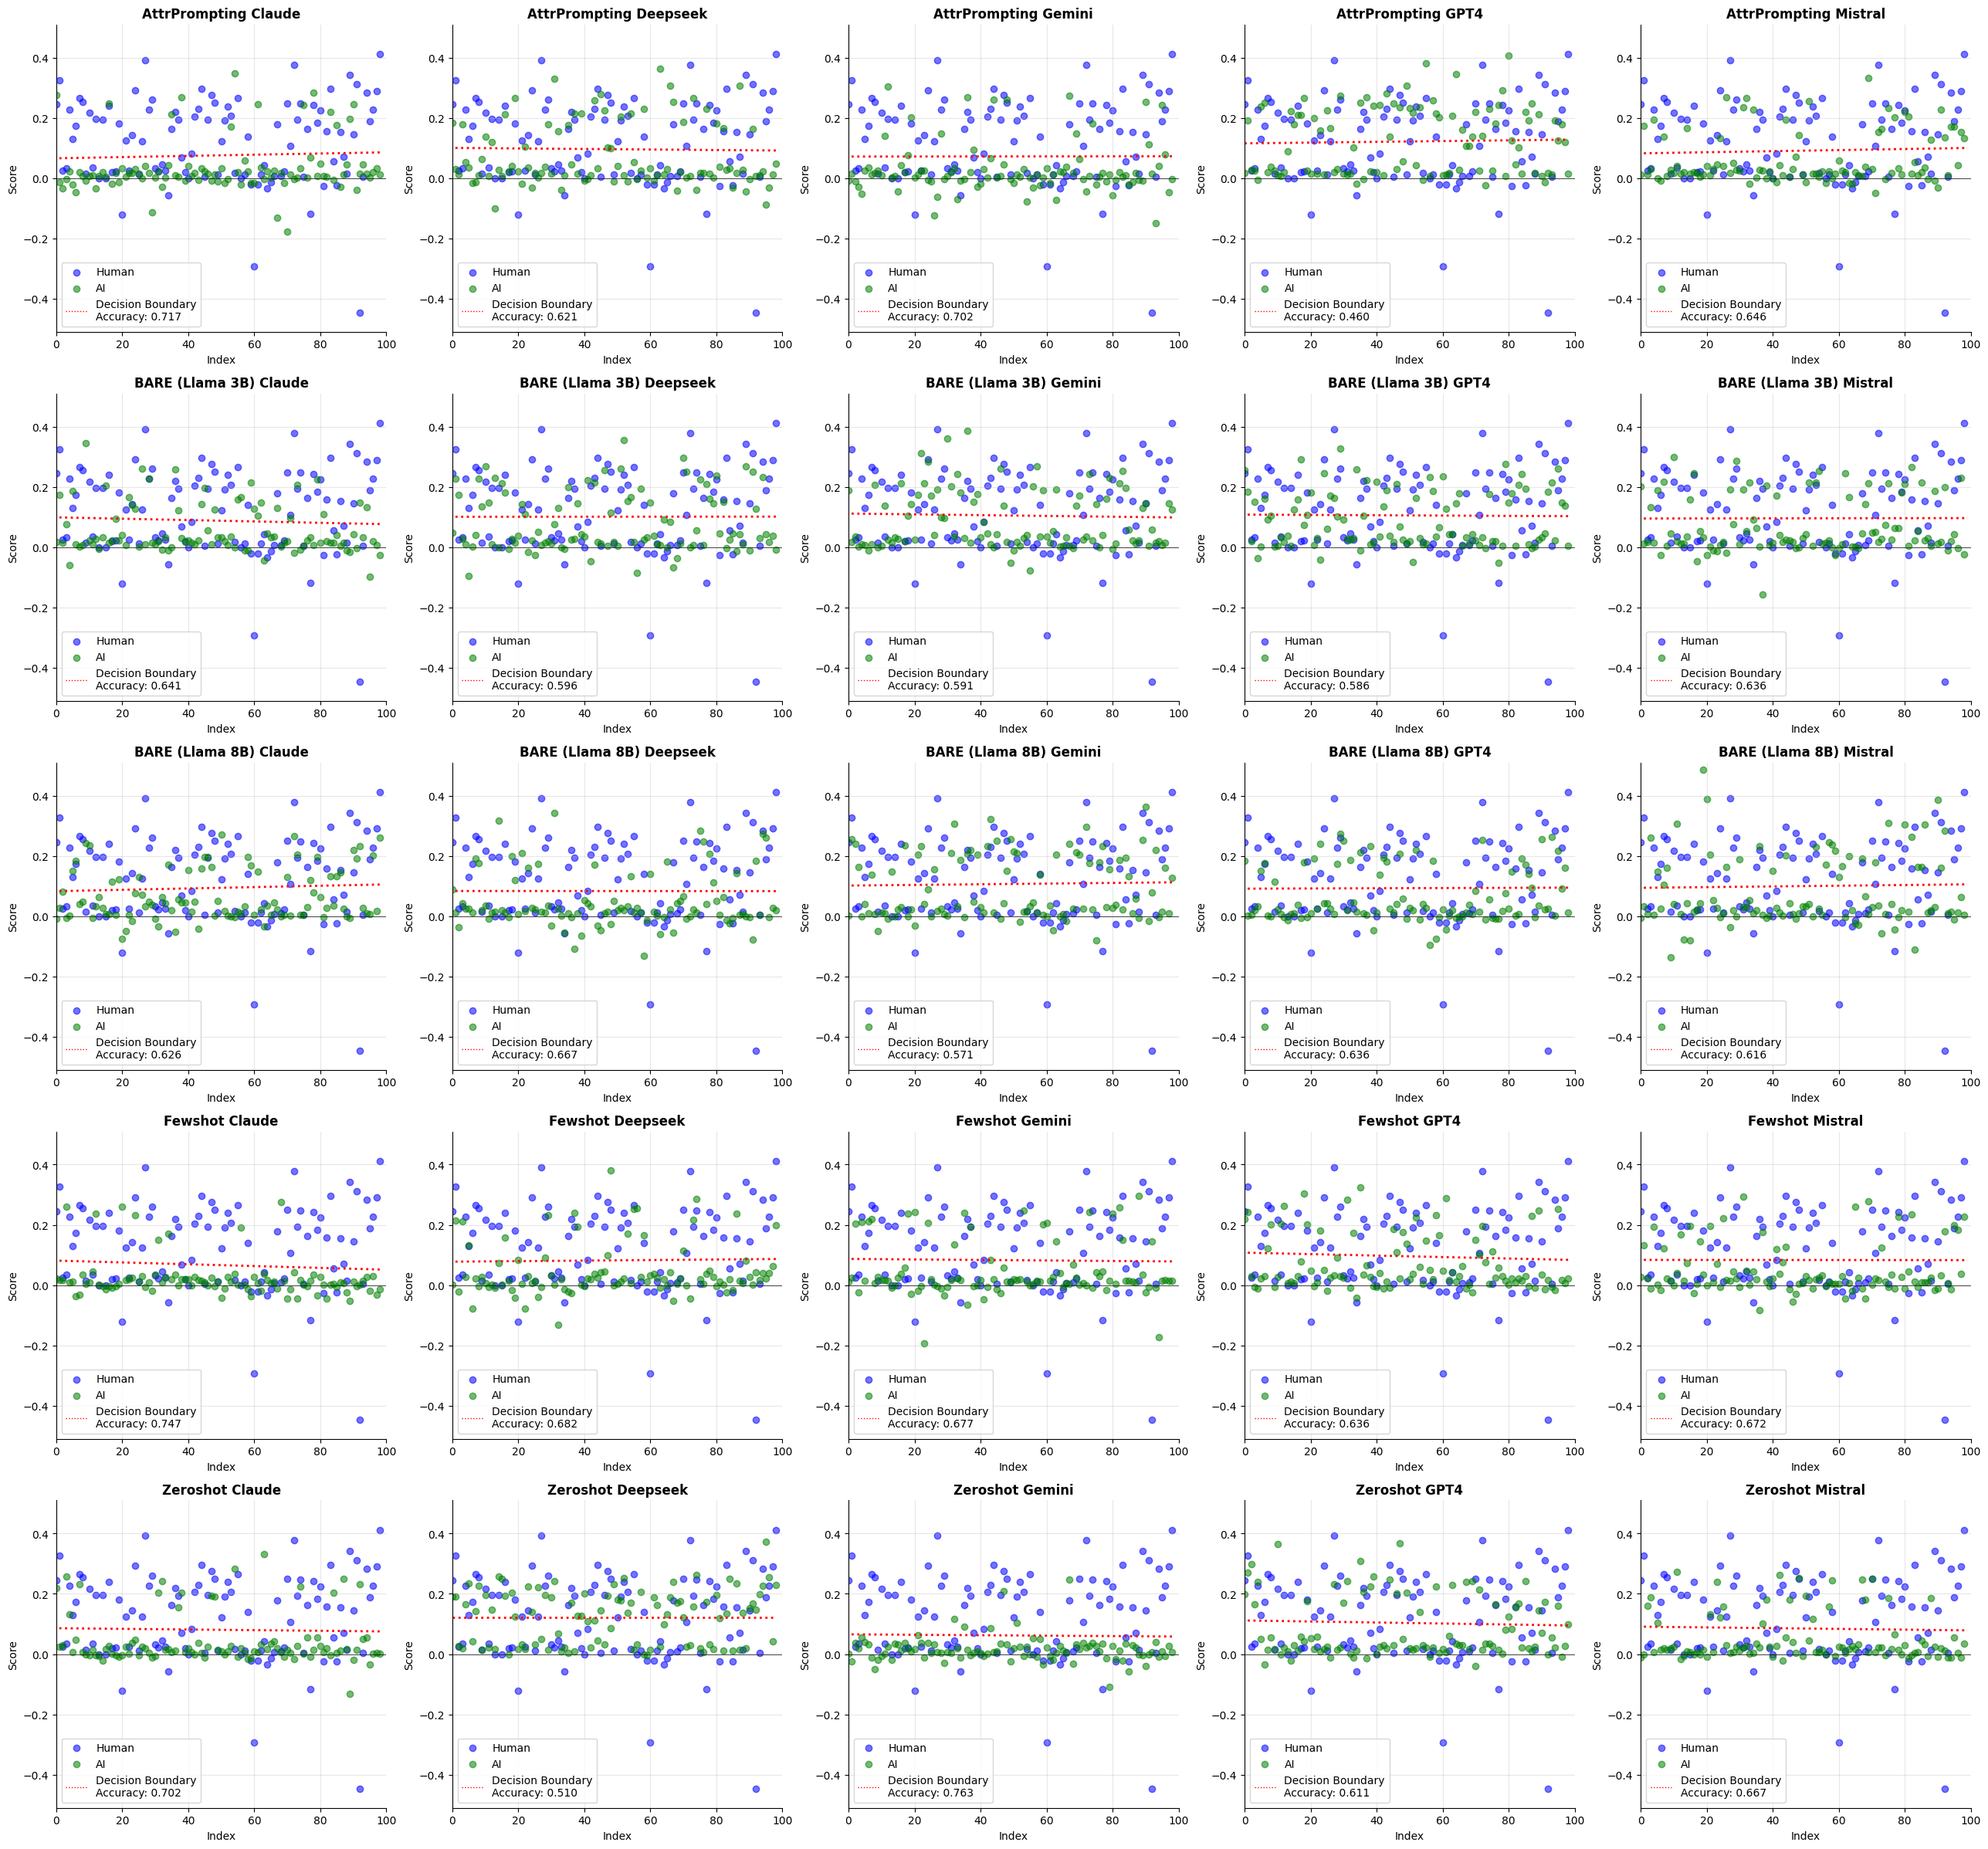

In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

def find_best_separation_line(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression(random_state=42)
    model.fit(X_scaled, y)
    
    y_pred = model.predict(X_scaled)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary', zero_division=0
    )
    accuracy = accuracy_score(y, y_pred)
    
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    
    stats = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'coef_index': coef[0],
        'coef_score': coef[1],
        'intercept': intercept
    }
    
    return model, scaler, stats

def plot_decision_boundary(ax, model, scaler, xlim, ylim, precision, recall, accuracy):
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 100),
        np.linspace(ylim[0], ylim[1], 100)
    )
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    
    Z = model.predict_proba(grid_points_scaled)[:, 1]
    Z = Z.reshape(xx.shape)
    
    contour = ax.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2, linestyles='dotted')
    
    return Line2D([0], [0], color='red', linestyle=':', linewidth=1,
                 label=f'Decision Boundary\nAccuracy: {accuracy:.3f}')

def visualize_raw_scores(directory_path):
    files = [f for f in os.listdir(directory_path) if f.endswith("_logratio.json")]
    
    if not files:
        print("No files with '_logratio.json' suffix found in the directory.")
        return None, None
    
    stats_data = []
    
    num_files = len(files)
    plots_per_row = 5
    num_rows = math.ceil(num_files / plots_per_row)
    
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(32, 6 * num_rows))
    
    if num_rows == 1 and plots_per_row == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = axes.reshape(1, -1)
    elif plots_per_row == 1:
        axes = axes.reshape(-1, 1)
    
    for i, file in enumerate(files):
        if i >= num_rows * plots_per_row:
            print(f"Warning: Not enough space in grid for file {file}")
            continue
            
        file_path = os.path.join(directory_path, file)
        title = file.replace("_s3_p15_logratio.json", "")
        title = " ".join(title.split("_"))
        title = title.title()
        title = title.replace("Gpt4", "GPT4").replace("Bare", "BARE").replace("Attr Prompting", "AttrPrompting").replace("BARE Llama3B", "BARE (Llama 3B)").replace("BARE Llama8B", "BARE (Llama 8B)")
        
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
        
        df["score_human"] = df.apply(lambda row: row.human_emails["score"] if isinstance(row.human_emails, dict) else np.nan, axis=1)
        df["score_ai"] = df.apply(lambda row: row.ai_emails["score"] if isinstance(row.ai_emails, dict) else np.nan, axis=1)
        
        df_scores = df[["score_human", "score_ai"]].dropna(axis=0)
        
        row_idx = i // plots_per_row
        col_idx = i % plots_per_row
        
        indices_human = df_scores.index.values
        indices_ai = df_scores.index.values
        
        X_human = np.column_stack((indices_human, df_scores.score_human.values))
        X_ai = np.column_stack((indices_ai, df_scores.score_ai.values))
        
        X = np.vstack((X_human, X_ai))
        y = np.hstack((np.zeros(len(X_human)), np.ones(len(X_ai))))
        
        model, scaler, stats = find_best_separation_line(X, y)
        
        file_stats = {
            'file_name': title,
            'num_samples': len(X),
            'num_human_samples': len(X_human),
            'num_ai_samples': len(X_ai),
            'human_score_mean': df_scores.score_human.mean(),
            'human_score_std': df_scores.score_human.std(),
            'human_score_min': df_scores.score_human.min(),
            'human_score_max': df_scores.score_human.max(),
            'ai_score_mean': df_scores.score_ai.mean(),
            'ai_score_std': df_scores.score_ai.std(),
            'ai_score_min': df_scores.score_ai.min(),
            'ai_score_max': df_scores.score_ai.max(),
            'score_difference': df_scores.score_ai.mean() - df_scores.score_human.mean()
        }
        
        file_stats.update(stats)
        
        stats_data.append(file_stats)
        
        human_scatter = axes[row_idx, col_idx].scatter(indices_human, df_scores.score_human, 
                                                 color="blue", label="Human", alpha=0.55)
        ai_scatter = axes[row_idx, col_idx].scatter(indices_ai, df_scores.score_ai, 
                                               color="green", label="AI", alpha=0.55)
        
        xlim = (min(indices_human.min(), indices_ai.min()), max(indices_human.max(), indices_ai.max()))
        ylim = (-0.51,0.51)
        axes[row_idx, col_idx].set_xlim(xlim)
        axes[row_idx, col_idx].set_ylim(ylim)
        
        boundary_line = plot_decision_boundary(
            axes[row_idx, col_idx], model, scaler, 
            xlim, ylim, stats['precision'], stats['recall'], stats['accuracy']
        )
        
        axes[row_idx, col_idx].legend(handles=[human_scatter, ai_scatter, boundary_line], loc='lower left')
        axes[row_idx, col_idx].set_title(f"{title}", fontweight='bold')
        axes[row_idx, col_idx].set_xlabel("Index")
        axes[row_idx, col_idx].set_ylabel("Score")
        axes[row_idx, col_idx].grid(True, alpha=0.3)
        axes[row_idx, col_idx].set_xlim(left=0,right=100)
        axes[row_idx, col_idx].axhline(0, color='black', linewidth=0.5)
        
    for i in range(num_files, num_rows * plots_per_row):
        row = i // plots_per_row
        col = i % plots_per_row
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].axis('off')

    plt.savefig("detectgpt_all_plots.png", dpi=300, bbox_inches='tight', transparent=False)
    plt.show()
    
    stats_df = pd.DataFrame(stats_data)
    
    return fig, stats_df

if __name__ == "__main__":
    directory_path = "../output/detectgpt/data"
    fig, stats_df = visualize_raw_scores(directory_path)

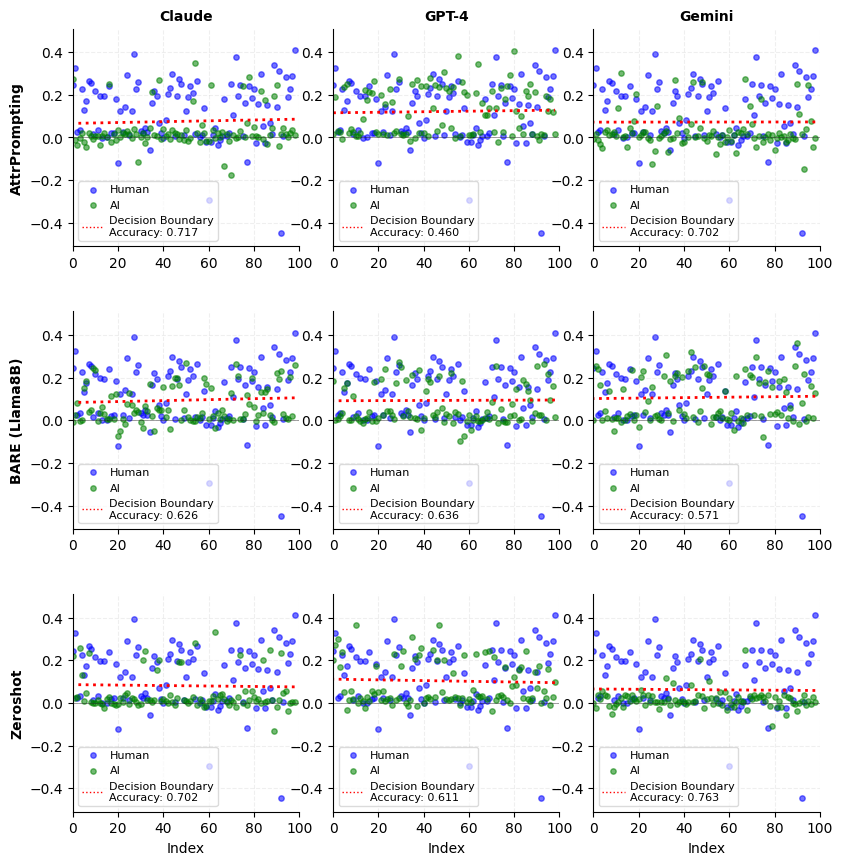

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

def find_best_separation_line(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression(random_state=42)
    model.fit(X_scaled, y)
    
    y_pred = model.predict(X_scaled)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary', zero_division=0
    )
    accuracy = accuracy_score(y, y_pred)
    
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    
    stats = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'coef_index': coef[0],
        'coef_score': coef[1],
        'intercept': intercept
    }
    
    return model, scaler, stats

def plot_decision_boundary(ax, model, scaler, xlim, ylim, precision, recall, accuracy):
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 100),
        np.linspace(ylim[0], ylim[1], 100)
    )
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    
    Z = model.predict_proba(grid_points_scaled)[:, 1]
    Z = Z.reshape(xx.shape)
    
    contour = ax.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2, linestyles='dotted')
    
    return Line2D([0], [0], color='red', linestyle=':', linewidth=1,
                 label=f'Decision Boundary\nAccuracy: {accuracy:.3f}')

def create_latex_friendly_grid(directory_path, output_dir="output/detectgpt"):
    """
    Create a LaTeX-friendly 3x3 grid for DetectGPT results with Attr_Prompting, BARE Llama-8B and Zeroshot methods.
    """
    if not os.path.exists(directory_path):
        return None
    
    selected_models = ['claude', 'gpt4', 'gemini']
    available_methods = ['attr_prompting', 'bare_llama8b', 'zeroshot']
    
    files = [f for f in os.listdir(directory_path) if f.endswith("_logratio.json")]
    selected_files = []
    
    for file in files:
        file_lower = file.lower()
        
        has_selected_model = any(model in file_lower for model in selected_models)
        has_available_method = any(method in file_lower for method in available_methods)
        
        if has_selected_model and has_available_method:
            selected_files.append(file)
    
    if not selected_files:
        return None
        
    plt.rcParams.update({
        'font.size': 10,
        'axes.linewidth': 0.8,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8
    })
    
    fig = plt.figure(figsize=(9, 9))
    
    gs = fig.add_gridspec(3, 3, 
                         left=0.15,
                         right=0.98, 
                         bottom=0.08, 
                         top=0.95, 
                         wspace=0.15,
                         hspace=0.3)
    
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)])
    
    method_row = {
        'attr_prompting': 0,
        'bare_llama8b': 1,
        'zeroshot': 2
    }
    
    model_col = {
        'claude': 0,
        'gpt4': 1,
        'gemini': 2
    }
    
    method_names = {
        'attr_prompting': 'AttrPrompting',
        'bare_llama8b': 'BARE (Llama8B)',
        'zeroshot': 'Zeroshot'
    }
    
    filled_positions = set()
    
    for file in selected_files:
        file_path = os.path.join(directory_path, file)
        file_lower = file.lower()
        
        model = next((m for m in selected_models if m in file_lower), None)
        method = next((m for m in available_methods if m in file_lower), None)
        
        if not model or not method:
            print(f"Skipping file {file} - couldn't determine model or method")
            continue
        
        row = method_row[method]
        col = model_col[model]
        
        filled_positions.add((row, col))
                
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
        
        df["score_human"] = df.apply(lambda row: row.human_emails["score"] if isinstance(row.human_emails, dict) else np.nan, axis=1)
        df["score_ai"] = df.apply(lambda row: row.ai_emails["score"] if isinstance(row.ai_emails, dict) else np.nan, axis=1)
        
        df_scores = df[["score_human", "score_ai"]].dropna(axis=0)
        
        indices_human = df_scores.index.values
        indices_ai = df_scores.index.values
        
        X_human = np.column_stack((indices_human, df_scores.score_human.values))
        X_ai = np.column_stack((indices_ai, df_scores.score_ai.values))
        
        X = np.vstack((X_human, X_ai))
        y = np.hstack((np.zeros(len(X_human)), np.ones(len(X_ai))))
        
        model_classifier, scaler, stats = find_best_separation_line(X, y)
        
        human_scatter = axes[row, col].scatter(indices_human, df_scores.score_human, 
                                             color="blue", label="Human", alpha=0.55, s=15)
        ai_scatter = axes[row, col].scatter(indices_ai, df_scores.score_ai, 
                                           color="green", label="AI", alpha=0.55, s=15)
        
        xlim = (min(indices_human.min(), indices_ai.min()), max(indices_human.max(), indices_ai.max()))
        ylim = (-0.51, 0.51)
        axes[row, col].set_xlim(left=0, right=100)
        axes[row, col].set_ylim(ylim)
        
        boundary_line = plot_decision_boundary(
            axes[row, col], model_classifier, scaler, 
            xlim, ylim, stats['precision'], stats['recall'], stats['accuracy']
        )
        
        axes[row, col].legend(handles=[human_scatter, ai_scatter, boundary_line], 
                             loc='lower left', fontsize=8, framealpha=0.7,
                             handletextpad=0.5, borderpad=0.3)
        
        model_title = "GPT-4" if model == "gpt4" else model.title()
        if row == 0:
            axes[row, col].set_title(f"{model_title}", fontsize=10, fontweight='bold')
           
        if row == 2:
            axes[row, col].set_xlabel("Index", fontsize=10)
            
        axes[row, col].axhline(0, color='black', linewidth=0.5, linestyle='-', alpha=0.5)
        axes[row, col].grid(True, linestyle='--', alpha=0.2)
    
    for row in range(3):
        for col in range(3):
            if (row, col) not in filled_positions:
                axes[row, col].axis('off')
    
    for row, method in enumerate(available_methods):
        if any((row, col) in filled_positions for col in range(3)):
            axes[row, 0].set_ylabel(method_names[method], fontsize=10, fontweight='bold')
    
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "detectgpt_latex_grid.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=False)
    
    return fig

if __name__ == "__main__":
    directory_path = "../output/detectgpt/data"
    output_dir = os.path.join(os.getcwd(), "output", "detectgpt")
    
    fig = create_latex_friendly_grid(directory_path, output_dir)